In [2]:
import novelty_serve
import pandas as pd
import numpy as np
import nltk.app.srparser_app
%matplotlib inline
from nltk.tokenize import TweetTokenizer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
novelty_serve.download_from_drive()

In [4]:
df_ = pd.read_csv("cleaned.csv")

In [5]:
def get_clusters(df,col):
    clusters = set(df[col].values)
    cluster_data = []
    for i in clusters:
        cluster_data.append(df[df[col]==i])
    return cluster_data

In [6]:
cluster = get_clusters(df_,"context_cluster")

In [11]:
stimuli_clusters = get_clusters(df_,"context_cluster")
novelty_cluster = []
usefulness_cluster = []
len_cluster = []
for i,e in enumerate(stimuli_clusters):
    novelty_cluster.append(e["novelty"].mean())
    usefulness_cluster.append(e["usefulness"].mean())
    len_cluster.append(e.shape[0])

In [ ]:
for cl in ["context_cluster","stimuli_cluster","response_cluster"]:
    df = get_clusters(df_,cl)
    col = cl[:-8]
    for i,df in enumerate(cluster):
        cluster_string = " ".join(df[col].values)
        tknzr = TweetTokenizer()
        words = tknzr.tokenize(cluster_string)

        stop_words = set(stopwords.words('english')) 
        words = [i.lower() for i in words if i not in stop_words]
        d = {x:words.count(x) for x in words}
        def plot_cloud(wordcloud):
            plt.figure(figsize=(40, 30))
            plt.imshow(wordcloud) 
            plt.savefig(f'./plots/{cl}_{i}.png')
            plt.axis("off")
            plt.clf() 

        wordcloud = WordCloud(width = 500, height = 300, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(cluster_string)
        plot_cloud(wordcloud)


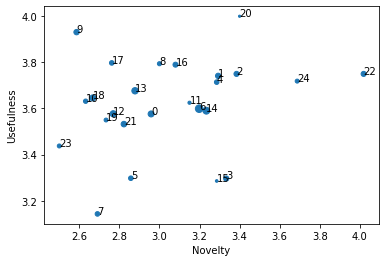

In [14]:

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(novelty_cluster,usefulness_cluster,len_cluster)
plt.xlabel("Novelty")
plt.ylabel("Usefulness")
for i,xy in enumerate(zip(novelty_cluster, usefulness_cluster)): 
    ax.annotate(i, xy=xy, textcoords='data') 
plt.savefig("./plots/novelty_usefulness_per_cluster_context.png")


In [9]:
list(zip(stimuli_clusters[23].context.values,stimuli_clusters[23].novelty.values))

[(&#39;Room is not empty&#39;, 1.0),
 (&#39;The person is not in the room.&#39;, 4.0),
 (&#39;The room senses movement in the room.&#39;, 1.5),
 (&#39;the room senses movement&#39;, 1.0),
 (&#39;The person is moving around in the room.&#39;, 1.5),
 (&#39;There is movement and activity in the kitchen.&#39;, 1.5),
 (&#39;There is movement in the room.&#39;, 1.0),
 (&#39;The ball is not a person, it creates movement in the room though. &#39;, 4.0),
 (&#39;There is movement in the bathroom &#39;, 2.5),
 (&#39;There is movement when I stand to get out of bed.&#39;, 3.0),
 (&#39;There is now motion in the dark room. &#39;, 1.0),
 (&#39;There is a movement in the hall. &#39;, 2.0),
 (&#39;There is motion in the room.&#39;, 4.5),
 (&#39;There is a movement in the main room.&#39;, 4.5),
 (&#39;There is a sudden movement in the room.&#39;, 2.5),
 (&#39;Multiple people in a room engaging in various activities &#39;, 4.5)]

In [10]:
list(zip(stimuli_clusters[7].context.values,stimuli_clusters[7].novelty.values))

[(&#39;The door sensor should recognize authorized entry &#39;, 1.0),
 (&#39;recognizing some authorized movements &#39;, 2.0),
 (&#39;The room sensor detected movement based on the first step and registers it.&#39;,
  2.5),
 (&#39;The system senses it&#39;, 2.5),
 (&#39;The system senses it&#39;, 3.0),
 (&#39;The system senses the voice&#39;, 4.0),
 (&#39;The living room did not lack movement to meet the preconfigured time. &#39;,
  4.0),
 (&#39;The movement should activate the application.&#39;, 3.0),
 (&#39;The movement activates the device.&#39;, 2.5),
 (&#39;The sensors should detect that I am moving towards the room&#39;, 1.0),
 (&#39;The smart lights are on. &#39;, 1.5),
 (&#39;My dog has an authorized collar.&#39;, 3.5),
 (&#39;The guard dog is authorized.&#39;, 3.0),
 (&#39;The user is authorized.&#39;, 4.5),
 (&#39;The sensors are set to a certain height.&#39;, 2.5),
 (&quot;Sensor&#39;s timer starts the countdown to preset value.&quot;, 3.0),
 (&quot;Sensor&#39;s timer start

In [15]:
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cuda')
model.cuda()

def summarize(text):
    preprocess_text = text.strip().replace("\n","")
    t5_prepared_Text = "summarize: "+preprocess_text
    tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)
    summary_ids = model.generate(tokenized_text,
                                        num_beams=5,
                                        no_repeat_ngram_size=2,
                                        min_length=10,
                                        max_length=100,
                                        early_stopping=True)
    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return output


In [16]:
df_["all"] = df_.apply(lambda x: x["context"]+" .\n "+x["stimuli"]+" .\n "+x["response"],axis=1)

In [9]:
from tqdm.auto import tqdm
tqdm.pandas()

df_["summary"] = df_["all"].progress_apply(lambda x:summarize(x))

In [10]:
df_["summary_len"] = df_["summary"].apply(lambda x: len(x))

In [18]:
df_["len"] = df_["all"].apply(lambda x: len(x))

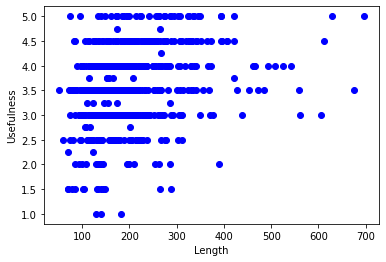

In [24]:
length = df_["len"].values
use = df_["usefulness"].values
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(length,use,'bo')
plt.xlabel("Length")
plt.ylabel("Usefulness")
plt.savefig("./plots/sumary_usefulness_vs_len.png")


In [25]:
model = novelty_serve.load_novelty_cnn()
model["model"].cuda()

DeepNoveltyCNN(
  (accumulator): Accumulator(
    (encoder): Attn_Encoder(
      (embedding): Embedding(30522, 300, padding_idx=0)
      (translate): Linear(in_features=300, out_features=400, bias=True)
      (act): Tanh()
      (lstm_layer): LSTM(400, 400, num_layers=2, bidirectional=True)
      (attention): Attention(
        (Ws): Linear(in_features=800, out_features=100, bias=False)
        (Wa): Linear(in_features=100, out_features=1, bias=False)
      )
    )
  )
  (linear): Linear(in_features=180, out_features=2, bias=True)
  (convs1): ModuleList(
    (0): Conv2d(1, 60, kernel_size=(4, 3200), stride=(1, 1))
    (1): Conv2d(1, 60, kernel_size=(6, 3200), stride=(1, 1))
    (2): Conv2d(1, 60, kernel_size=(9, 3200), stride=(1, 1))
  )
  (act): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [48]:
from tqdm.notebook import tnrange

novelty_scores = df_["novelty"].values
all = df_["all"].values
usefulness_scores = df_["usefulness"].values
data = df_["response"].values

comparision_set_src = []
comparision_set_trg = []
ids=[]
for i in tnrange(len(data)-1):
    for j in range(i+1,len(data)):
        x=data[i]
        y=data[j]
        comparision_set_src.append(x)
        comparision_set_trg.append(y)
        ids.append((i,j))

novelty_scores = novelty_serve.predict_novelty(comparision_set_src,comparision_set_trg,model)




In [49]:
novelty_ratings = df_["novelty"].values
usefulness_ratings = df_["usefulness"].values
all_text = df_["all"].values
novelty_score_novel = [i[1] for i in novelty_scores]

other_values = [(novelty_ratings[i],novelty_ratings[j],usefulness_ratings[i],usefulness_ratings[j],all_text[i],all_text[j])for i,j in ids]
other_values = map(list,zip(*other_values))
all_pairs = zip(comparision_set_src,comparision_set_trg,ids,novelty_score_novel,*other_values)

In [50]:
response_novelty = pd.DataFrame(all_pairs)
response_novelty.columns=["src_sent",'trg_sent',"ids","model_score","novelty_src","novelty_trg","usefulness_src","usefulness_trg","all_text_src","all_text_trg"]

In [51]:
response_novelty.to_excel('response_comparision.xlsx')

In [47]:
stimuli_novelty.shape

(203841, 10)

In [43]:
for i in all_pairs:
    print(i)
    break

(&#39;if i get up late night&#39;, &#39;if there is movement outside of the house&#39;, (0, 1), 0.47696784138679504, (1.5, 2.0, 3.0, 1.5, &#39;my sensor should detect movement .\n if i get up late night .\n lights in  my house should go on&#39;, &#39;movement should be detected .\n if there is movement outside of the house .\n lights should go on for visibility during the dark night&#39;))


In [62]:
new_df = pd.merge(stimuli_novelty,response_novelty,left_on=["ids","novelty_src","novelty_trg","all_text_src","usefulness_src","usefulness_trg","all_text_src","all_text_trg"],right_on=["ids","novelty_src","novelty_trg","all_text_src","usefulness_src","usefulness_trg","all_text_src","all_text_trg"])

In [64]:
new_df.columns = ["src_sent_stimuli","trg_sent_stimuli","ids","stimuli_novelty","novelty_src","novelty_trg","usefulness_src","usefulness_trg","all_text_src","all_text_trg","src_sent_response","trg_sent_response","response_novelty"]

In [28]:
# new_df.to_excel("pair_novelty.xlsx")
new_df = pd.read_excel("pair_novelty.xlsx")

In [67]:
new_df["novelty_score"]=(new_df["stimuli_novelty"]**2 + new_df["response_novelty"]**2)**0.5

In [84]:
ids = set([j for i in new_df[new_df["novelty_score"]<0.3]["ids"].values for j in i])

3.5153846153846153

1. Avergae distance from its 10 closest neighbours

In [91]:
new_df["src_id"] = new_df["ids"].apply(lambda x:x[0])
new_df["trg_id"] = new_df["ids"].apply(lambda x:x[1])

In [95]:
new_df = new_df.drop(columns=["ids"])

In [142]:
all_ids = set(new_df["src_id"].values).union(set(new_df["trg_id"].values))

In [143]:
overall_novelty = {}
for id_no in all_ids:
    id_df = new_df[(new_df["src_id"]==id_no) | (new_df["trg_id"]==id_no)]
    overall_novelty[id_no] = id_df["novelty_score"].mean()


In [144]:
novel = sorted(overall_novelty.items(),key = lambda x:x[1],reverse = True)[:10]
non_novel = sorted(overall_novelty.items(),key = lambda x:x[1])[:10]


In [145]:
df_.iloc[[i[0] for i in novel]]["novelty"].sum()

34.5

In [146]:
df_.iloc[[i[0] for i in non_novel]]["novelty"].sum()

26.0

In [147]:
df_["novelty_cnn"] = list(overall_novelty.values())

In [27]:
# df_.to_excel('cnn_novelty_crowd_re.xlsx')
df_ =pd.read_excel("cnn_novelty_crowd_re.xlsx")

In [31]:
from scipy.stats import pearsonr

In [60]:
pearsonr(df_["usefulness"].values,df_["len"].values)

(0.2701818131726367, 3.758076833745697e-12)

In [59]:
import pingouin as pg
pg.corr(x=df_["len"], y=df_["usefulness"])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,639,0.270182,"[0.2, 0.34]",0.072998,0.070083,3.758077e-12,1.404e+09,1.0


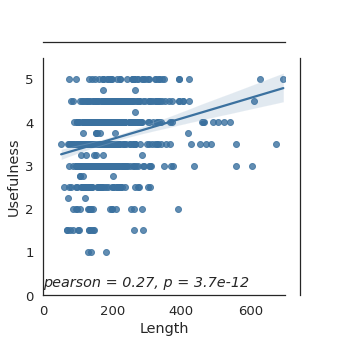

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
sns.set(style='white', font_scale=1.2)

g = sns.JointGrid(data=df_, x='len', y='usefulness', height=5, xlim = (0,700),ylim=(0,5.5))
g = g.plot_joint(sns.regplot, color="xkcd:muted blue")
g= g.set_axis_labels('Length', 'Usefulness')
# g = g.plot_marginals(sns.distplot, kde=False, bins=5, color="xkcd:bluey grey")
g.ax_joint.text(1, 0.2, 'pearson = 0.27, p = 3.7e-12', fontstyle='italic')
plt.tight_layout()
plt.savefig("./plots/sumary_usefulness_vs_len.png")